In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


In [2]:
df = pd.read_csv("data/combined_csv_v1.csv")
df.head(3)

,target,Distance,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Early Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,1464.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
1,1.0,1464.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,0.0,1464.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False


In [3]:
# Convert boolean columns to 0 and 1
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)  # Converting True to 1 and False to 0

In [4]:
df.dtypes

target                        float64
Distance                      float64
Month_2                       float64
Month_3                       float64
Month_4                       float64
Month_5                       float64
Month_6                       float64
Month_7                       float64
Month_8                       float64
Month_9                       float64
Month_10                      float64
Month_11                      float64
Month_12                      float64
DayOfWeek_2                   float64
DayOfWeek_3                   float64
DayOfWeek_4                   float64
DayOfWeek_5                   float64
DayOfWeek_6                   float64
DayOfWeek_7                   float64
Reporting_Airline_DL          float64
Reporting_Airline_OO          float64
Reporting_Airline_UA          float64
Reporting_Airline_WN          float64
Origin_CLT                    float64
Origin_DEN                    float64
Origin_DFW                    float64
Origin_IAH  

In [5]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df, test_size=0.3, random_state=42,stratify=df['target'])
validation, test = train_test_split(validation, test_size = 0.5,random_state=42)

In [6]:
train.to_csv("data/q2a/train.csv", index = False, header = False)
validation.to_csv("data/q2a/validation.csv", index = False, header = False)
test.to_csv("data/q2a/test.csv", index = False, header = False)

In [7]:
test_X =  test.drop("target", axis = 1)
test_y = test["target"]
test_X.to_csv("data/q2a/test.csv", index = False, header = False)

In [8]:
import sagemaker
import boto3
from sagemaker import image_uris


sess = sagemaker.Session()
bucket = sess.default_bucket()


region = boto3.Session().region_name
container = image_uris.retrieve('xgboost', region,version='latest')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [9]:
prefix = "final_assignment/q2a"
train_path = sess.upload_data(path="./data/q2a/train.csv", key_prefix=prefix + "/input/training")
valid_path = sess.upload_data(path="./data/q2a/validation.csv", key_prefix=prefix + "/input/validation")
test_X_path = sess.upload_data(path="./data/q2a/test.csv", key_prefix=prefix + "/input/test")

In [10]:
from sagemaker.estimator import Estimator


xgb_estimator = Estimator(container,
                          role=sagemaker.get_execution_role(),
                          instance_count=1,
                          instance_type='ml.m4.xlarge',
                          output_path='s3://{}/{}/output'.format(bucket,prefix))

In [11]:
xgb_estimator.set_hyperparameters(objective='binary:logistic', num_round=15)


In [12]:
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')

In [13]:
xgb_estimator.fit({'train': training_data_channel,'validation': validation_data_channel})


INFO:sagemaker:Creating training-job with name: xgboost-2024-11-03-03-26-53-155


2024-11-03 03:26:54 Starting - Starting the training job...
2024-11-03 03:27:08 Starting - Preparing the instances for training...
2024-11-03 03:27:30 Downloading - Downloading input data...
2024-11-03 03:28:05 Downloading - Downloading the training image...
2024-11-03 03:28:51 Training - Training image download completed. Training in progress...Arguments: train
[2024-11-03:03:29:04:INFO] Running standalone xgboost training.
[2024-11-03:03:29:04:INFO] File size need to be processed in the node: 225.9mb. Available memory size in the node: 8448.73mb
[2024-11-03:03:29:04:INFO] Determined delimiter of CSV input is ','
[03:29:04] S3DistributionType set as FullyReplicated
[03:29:06] 1144913x41 matrix with 46941433 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-11-03:03:29:06:INFO] Determined delimiter of CSV input is ','
[03:29:06] S3DistributionType set as FullyReplicated
[03:29:06] 245338x41 matrix with 10058858 entries loaded from /opt/ml/input/da

In [15]:
xgb_predictor = xgb_estimator.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2024-11-03-03-32-05-851
INFO:sagemaker:Creating endpoint-config with name xgboost-2024-11-03-03-32-05-851
INFO:sagemaker:Creating endpoint with name xgboost-2024-11-03-03-32-05-851


------!

In [17]:
test.shape

(245339, 42)

In [18]:

xgb_transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}/batch_output"
)

INFO:sagemaker:Creating model with name: xgboost-2024-11-03-03-36-32-681


In [19]:
xgb_transformer.transform(test_X_path, content_type="text/csv", split_type="Line")
xgb_transformer.wait()

INFO:sagemaker:Creating transform job with name: xgboost-2024-11-03-03-36-35-500


....................................
Arguments: serve
Arguments: serve
[2024-11-03 03:42:34 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2024-11-03 03:42:34 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2024-11-03 03:42:34 +0000] [1] [INFO] Using worker: gevent
[2024-11-03 03:42:34 +0000] [21] [INFO] Booting worker with pid: 21
[2024-11-03 03:42:35 +0000] [22] [INFO] Booting worker with pid: 22
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subpr

In [20]:
import boto3

s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
if 'Contents' in response:
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the specified prefix.")

final_assignment/q2a/batch_output/test.csv.out
final_assignment/q2a/input/test/test.csv
final_assignment/q2a/input/training/train.csv
final_assignment/q2a/input/validation/validation.csv
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/debug-output/training_job_end.ts
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/output/model.tar.gz
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/profiler-output/framework/training_job_end.ts
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/profiler-output/system/incremental/2024110303/1730604420.algo-1.json
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/profiler-output/system/incremental/2024110303/1730604480.algo-1.json
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/profiler-output/system/incremental/2024110303/1730604540.algo-1.json
final_assignment/q2a/output/xgboost-2024-11-03-03-26-53-155/profiler-output/system/training_job_end.ts


In [22]:
import io

y_file = boto3.client("s3").get_object(Bucket = bucket, Key = "final_assignment/q2a/batch_output/test.csv.out")

y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header = None, names = ["Predicted"])

In [23]:
y_pred["actual"] = y_pred["Predicted"].apply(lambda x : 1 if x > 0.5 else 0)

# Accuracy Score


In [24]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(test_y, y_pred["actual"])
print("Accuracy:", accuracy)

Accuracy: 0.7906610852738456


In [25]:
test_labels = test.iloc[:,0]


In [26]:
test_labels

1163410    0.0
1029565    1.0
1317789    0.0
930136     1.0
1329099    1.0
          ... 
146216     0.0
217379     0.0
1099763    0.0
1515192    0.0
1054280    0.0
Name: target, Length: 245339, dtype: float64

In [27]:
y_pred

,Predicted,actual
0,0.128339,0
1,0.171214,0
2,0.178545,0
3,0.293887,0
4,0.332872,0
...,...,...
245334,0.193505,0
245335,0.184472,0
245336,0.292248,0
245337,0.218220,0


# Creating a confusion matrix


In [28]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, y_pred['actual'])
df_confusion = pd.DataFrame(matrix, index=['no_delay','delay'],columns=['no_delay','delay'])

df_confusion

,no_delay,delay
no_delay,193533,300
delay,51059,447


To start, extract the values from the confusion matrix cells into variables.

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, y_pred['actual']).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 193533
False Positive (FP): 300
False Negative (FN): 51059
True Positive (TP) : 447


### Sensitivity

Sensitivity is also known as *hit rate*, *recall*, or *true positive rate (TPR)*. It measures the proportion of the actual positives that are correctly identified.

In [39]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting delay have an actual delay")

Sensitivity or TPR: 0.867860055139207%
There is a 0.867860055139207% chance of detecting delay have an actual delay


# Specificity
The next statistic is *specificity*, which is also known as the *true negative*. It measures the proportion of the actual negatives that are correctly identified.

In [40]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting delay as delay.")

Specificity or TNR: 99.84522759282474%
There is a 99.84522759282474% chance of detecting delay as delay.


# Precision
The *precision*, or *positive predictive value*, is the proportion of positive results.

In [41]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an delay, and the probablity that is correct is {Precision}%")

Precision: 59.83935742971887%
You have an delay, and the probablity that is correct is 59.83935742971887%


# Summary
In summary, you calculated the following metrics from your model:

In [33]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Accuracy: {accuracy}%")

Sensitivity or TPR: 0.867860055139207%
Specificity or TNR: 99.84522759282474%
Precision: 59.83935742971887%
Accuracy: 0.7906610852738456%


# Calculating the AUC-ROC Curve

- The ROC is a probability curve.
- The AUC tells you how well the model can distinguish between classes. 


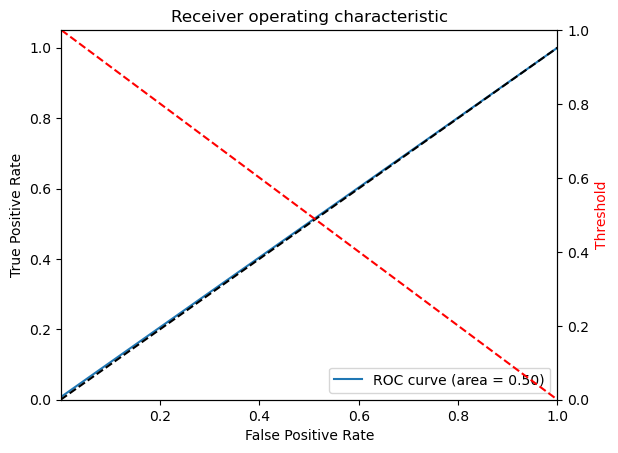

In [38]:
fpr, tpr, thresholds = roc_curve(test_labels, y_pred['actual'])

finite_indices = np.isfinite(thresholds) 
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(fpr_finite, tpr_finite, label='ROC curve (area = %0.2f)' % auc(fpr_finite, tpr_finite))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(fpr_finite, thresholds_finite, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()